__Change current directory__

In [1]:
import os
os.chdir('..')

### Import libraries and modules

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from timeit import default_timer
import pandas as pd
import seaborn as sns
from src import detector_descriptor as dd
from src import data as dt
from src import util
from src import experiments as ex
from src import imgop as ip
import cv2
import yaml
# plt.style.use('fast')


__Load configuration__

In [3]:
with open(os.path.join('./', 'config.yml'), 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
    cfg = cfg['default']

__Load image set__

In [4]:
dataset_path = cfg['path']['dataset']
dataset = cfg['current_dataset']
# labels = dt.load_labels(os.path.join(dataset_path, dataset), '.txt')
pckl_path = cfg['path']['pckl']
# pckl_name = ''.join([dataset, '_label.pckl'])
data_path = os.path.join(pckl_path, ''.join([dataset, '.pckl']))

#### Image set to variance

In [10]:
image_set_variance = {
    'bark': 'zoom_rotation', 
    'boat': 'zoom_rotation',
    'leuven': 'light',
    'bikes': 'image-blur', 
    'trees': 'image-blur',
    'wall': 'viewpoint',
    'graf': 'viewpoint',
    'ubc': 'jpeg-compression'
}



In [11]:
colors = ['olive', 'red', 'cyan', 'blue', 'purple', 'green', 'grey', 'orange', 'indigo', 'black']

##### Show all images from an image set

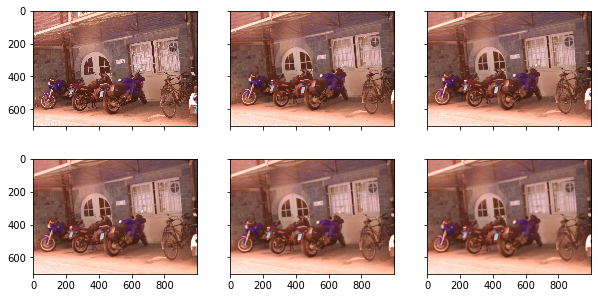

In [12]:
# all_detectors = dd.get_all_detectors()
# print(list(all_detectors.keys()))
image_set = util.get_image_set(data_path, 'bikes')
util.show_image_set(image_set)

In [13]:
plt.rcParams["font.family"] = "Times New Roman"

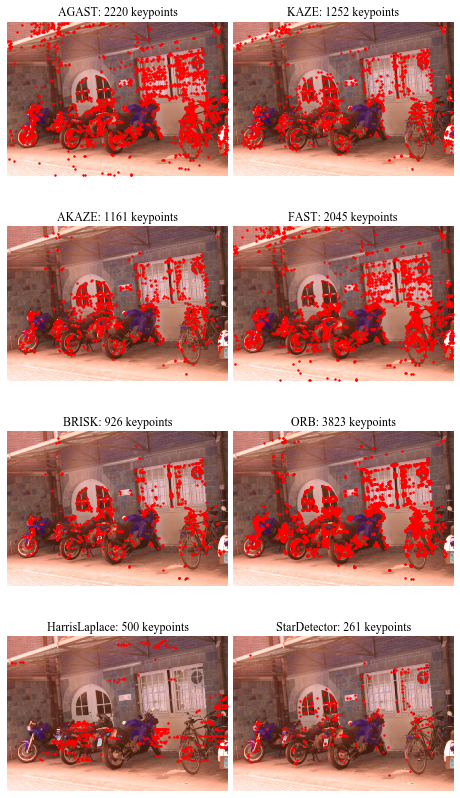

In [20]:
image_set_ = util.get_image_set(data_path, 'bikes')
image_num = 3
image = image_set_['{0}_img{1}'.format('bikes', image_num)]
all_kp = {}
row = 4
col = 2
fig, axs = plt.subplots(row, col, figsize=(8,15), sharex=True, sharey=True)
for detector_name in dd.all_detectors:
    all_kp[detector_name] = ip.get_kp(image, detector_name)
kpnp = ip.cvkp2np_all(all_kp)
i = 0
for detector_name in kpnp.keys():
    x = kpnp[detector_name][:,0]
    y = kpnp[detector_name][:,1]
    axs[i // col, i % col].imshow(image)
    axs[i // col, i % col].scatter(x,y, c='r', s=2)
    # Hide grid lines
#     axs[i // 3, i % 3].grid(False)
    axs[i // col, i % col].axis('off')

    # Hide axes ticks
    axs[i // col, i % col].set_xticks([])
    axs[i // col, i % col].set_yticks([])
    axs[i // col, i % col].set_title(f'{detector_name}: {kpnp[detector_name].shape[0]} keypoints')
#     axs[i // 3, i % 3].set_zticks([])
    i += 1
fig.subplots_adjust(wspace = 0.02, hspace = 0.02)


# plt.axis('off')
# plt.grid(b=None)
plt.show()

### First experiment
Visualize total number of keypoints vs execution time for corresponding detectors

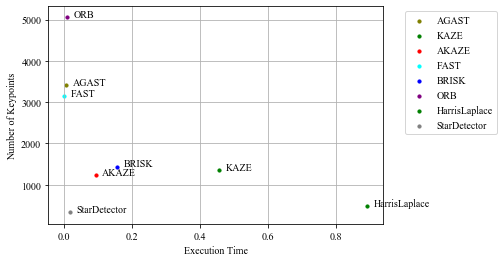

In [21]:
image_set_ = util.get_image_set(data_path, 'bikes')
image_num = 2
image = image_set_['{0}_img{1}'.format('bikes', image_num)]
fig = plt.figure()
ax = fig.add_subplot(111)
ex.exp_det_kpet_plt(image, ax)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.grid()
plt.show()

Number of total keypoints and execution time for each detector type for an image

In [22]:
image_set_name = 'bikes'
image_set_ = util.get_image_set(data_path, image_set_name)
image_num = 4
image = image_set_['{0}_img{1}'.format(image_set_name, image_num)]
df = ex.experiment_1_df(image)
df.style. \
    apply(util.highlight_max, subset=['Execution Time', 'Number of Keypoints']). \
    apply(util.highlight_min, subset=['Execution Time', 'Number of Keypoints'])


,Detector,Execution Time,Number of Keypoints
0,AGAST,0.005747,1115
1,KAZE,0.448934,928
2,AKAZE,0.103764,970
3,FAST,0.001281,1039
4,BRISK,0.155352,561
5,ORB,0.006459,2196
6,HarrisLaplace,0.878351,376
7,StarDetector,0.019183,175


#### Visualize average total number of keypoints vs average execution time for corresponding detectors for a certain image set

In [23]:
image_set_arr = ['leuven', 'bikes', 'ubc']
plot_data_arr = []

for image_set_name in image_set_arr: 
    image_set = util.get_image_set(data_path, image_set_name)
    avg_execution_time, avg_total_keypoints = ip.get_det_avg_numkp_et(image_set)
    plot_data = {}
    for name in avg_execution_time.keys():
        plot_data[name] = [avg_execution_time[name], avg_total_keypoints[name]]
    plot_data_arr.append(plot_data)

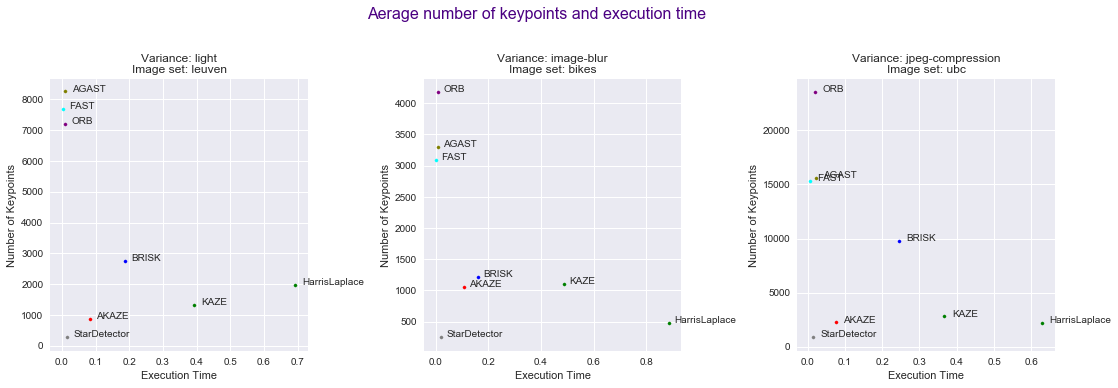

In [24]:
# sns.set_style("darkgrid")
# plt.style.use('seaborn')

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
colors = ['olive', 'green', 'red', 'cyan', 'blue', 'purple', 'green', 'grey', 'orange', 'brown']

plot_data_index = 0
for plot_data in plot_data_arr:
    color_index = 0
    for key, values in plot_data.items():
        x, y = values
        axs[plot_data_index].scatter(x, y, c=colors[color_index], s=10, label=key)
        axs[plot_data_index].annotate(key, xy=(x+0.02, y), textcoords='data')
        color_index += 1
    axs[plot_data_index].grid(True)
    # axs[1].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    axs[plot_data_index].set_xlabel("Execution Time")
    axs[plot_data_index].set_ylabel("Number of Keypoints")
    variance = image_set_variance[image_set_arr[plot_data_index]]
    image_set_name = image_set_arr[plot_data_index]
    axs[plot_data_index].set_title(f"Variance: {variance}\nImage set: {image_set_name}")
    plot_data_index += 1
fig.subplots_adjust(wspace = 0.45)
plt.suptitle('Aerage number of keypoints and execution time', fontsize = 16, y = 1.08, color='indigo')
plt.show()

#### Gradual blurring
The runtime and number of keypoints detected as the image is progressively blurred
##### Observations:
- Harris Laplace has the highest runtime 0.85 seconds. KAZE has a runtime of ~0.45s and the rest falls wihtin a very close range ~0.001 to ~0.03 
- All the detectors trends downward while only GFTT detects more keypoints for the 'bikes' image set.

In [25]:
image_set_arr = ['leuven', 'bikes', 'ubc']
plot_data_arr = []

for image_set_name in image_set_arr: 
    image_set = util.get_image_set(data_path, image_set_name)  
    plot_data = {}
    for detector_name in dd.all_detectors:    
#     if detector_name in ['FAST', 'AGAST']:
#         continue
#         execution_time, total_keypoints 
        plot_data[detector_name]= ip.get_det_kp_et(image_set, detector_name)
    plot_data_arr.append(plot_data)
print(len(plot_data_arr))

3


In [ ]:
_, a=plot_data_arr[1]['GFTT']

In [ ]:
b = [len(value) for value in a.values()]
print(b)

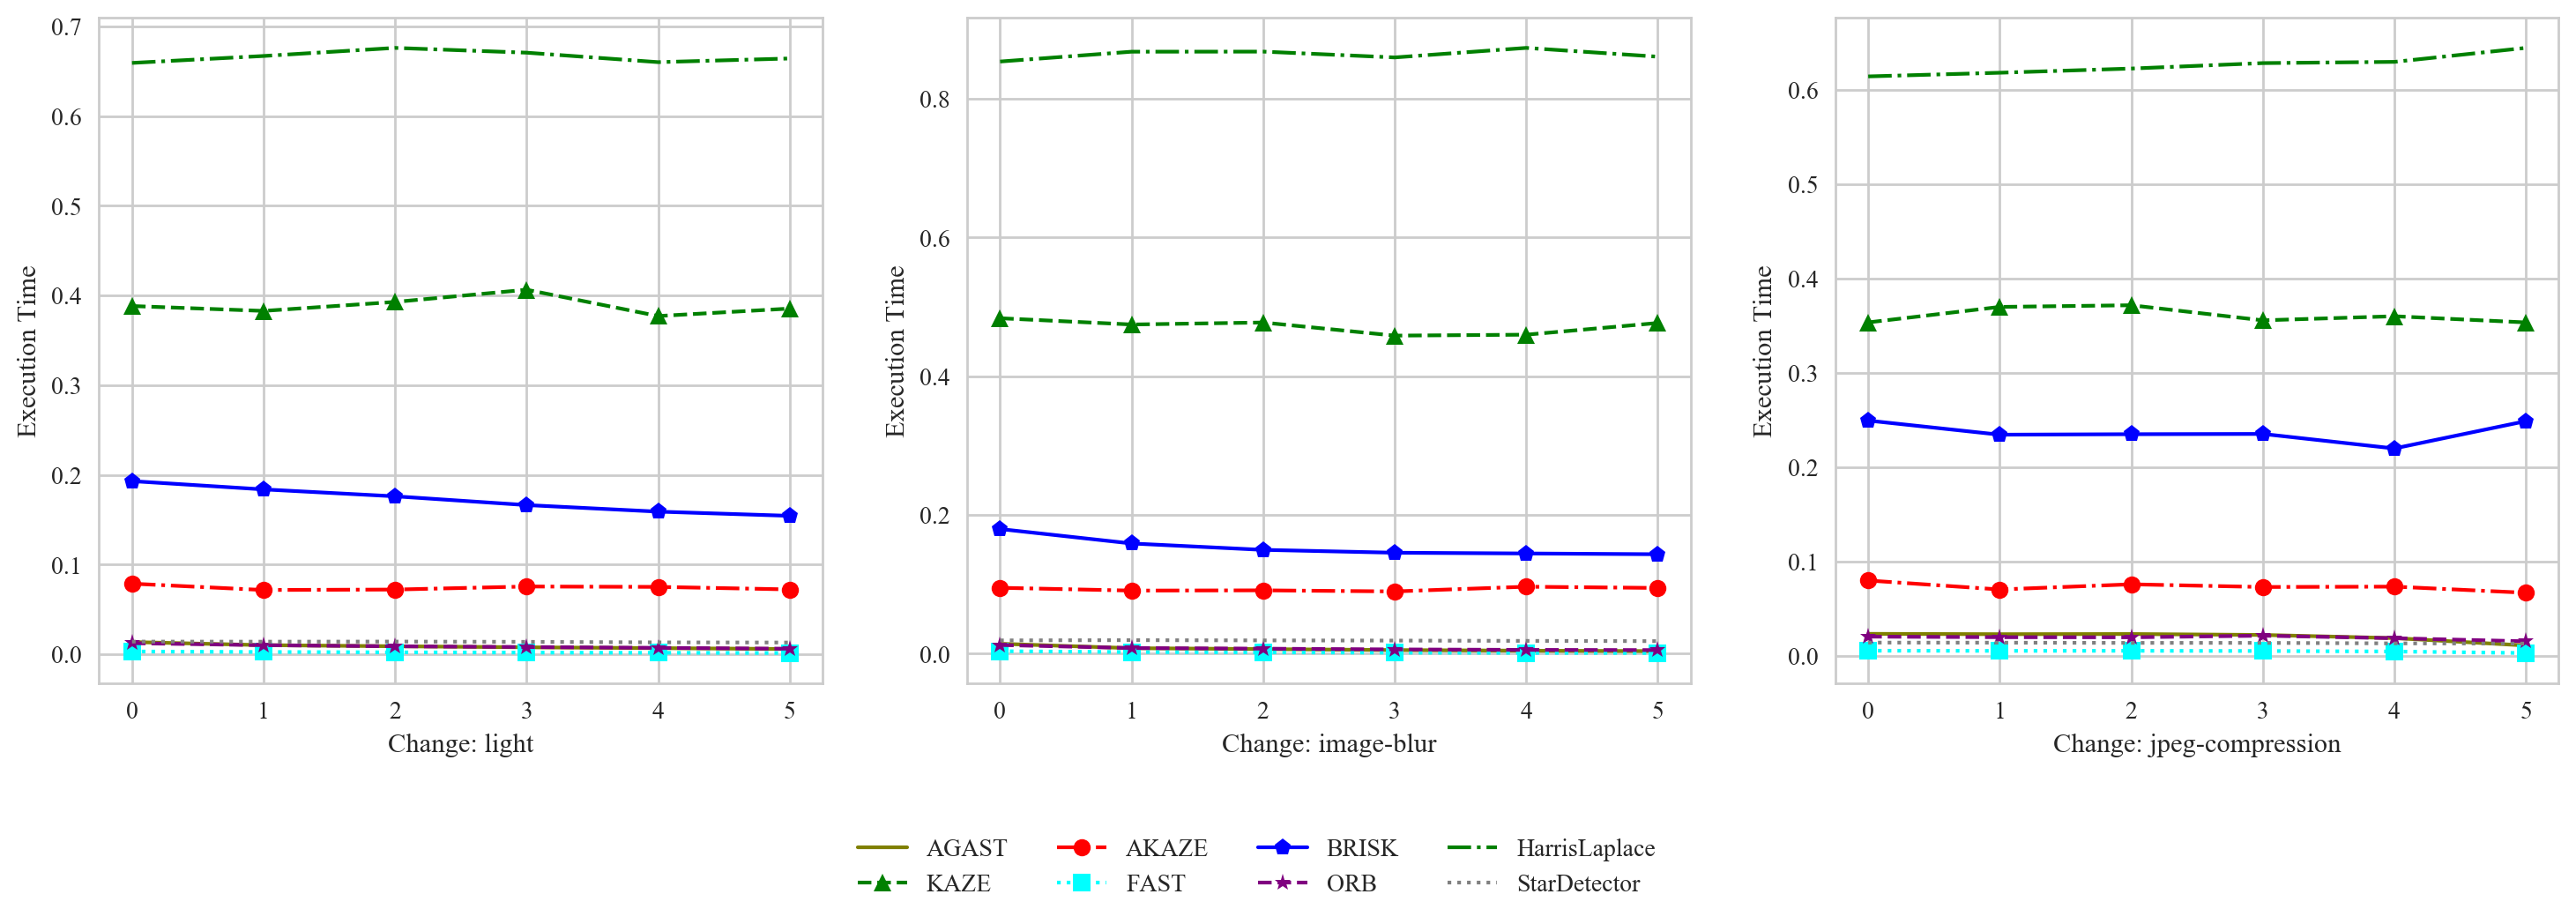

In [27]:
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 
# 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid',
# 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
linestyle_ = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
markers = ['+', '^', 'o', 's', 'p', '*', 'x', '+', '^', 'o', 's', 'p', '*', 'x']
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"

fig1, axs1 = plt.subplots(1, 3, figsize=(18,5), dpi=200)
# fig2, axs2 = plt.subplots(1, 3, figsize=(18,8), dpi=300)
axs_col = 0
for plot_data in plot_data_arr:
    i = 0
    for detector_name in dd.all_detectors: 
        execution_time, total_keypoints = plot_data[detector_name]
        axs1[axs_col].plot(list(execution_time.keys()), list(execution_time.values()), linestyle=linestyle_[i], 
                           linewidth=1.5, marker=markers[i], c=colors[i], label=detector_name)
#         axs2[axs_col].plot(list(total_keypoints.keys()), [len(value) for value in total_keypoints.values()], 
#                              c=colors[i], label=detector_name)
        i += 1
#     axs[0, axs_col].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    variance = image_set_variance[image_set_arr[axs_col]]
    axs1[axs_col].set_xlabel(f'Change: {variance}')
    axs1[axs_col].set_ylabel("Execution Time")
    
#     axs[1, axs_col].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
#     axs2[axs_col].set_xlabel(f'Variance: {variance}')
#     axs2[axs_col].set_ylabel("Number of keypoints")
    axs_col += 1
#     print(image_set_name)
handles1, labels1 = axs1[0].get_legend_handles_labels()
# handles2, labels2 = axs2[0].get_legend_handles_labels()
plt.legend(handles1, labels1, loc="upper center",bbox_to_anchor=(-0.8, -0.2), ncol = 4)
fig1.subplots_adjust(wspace = 0.2)
# fig2.subplots_adjust(wspace = 0.2)
# plt.suptitle('Execution time and total number of keypoints \ndetected accross different levels of variance', fontsize = 16, y = 1.0, color='indigo')
plt.show()

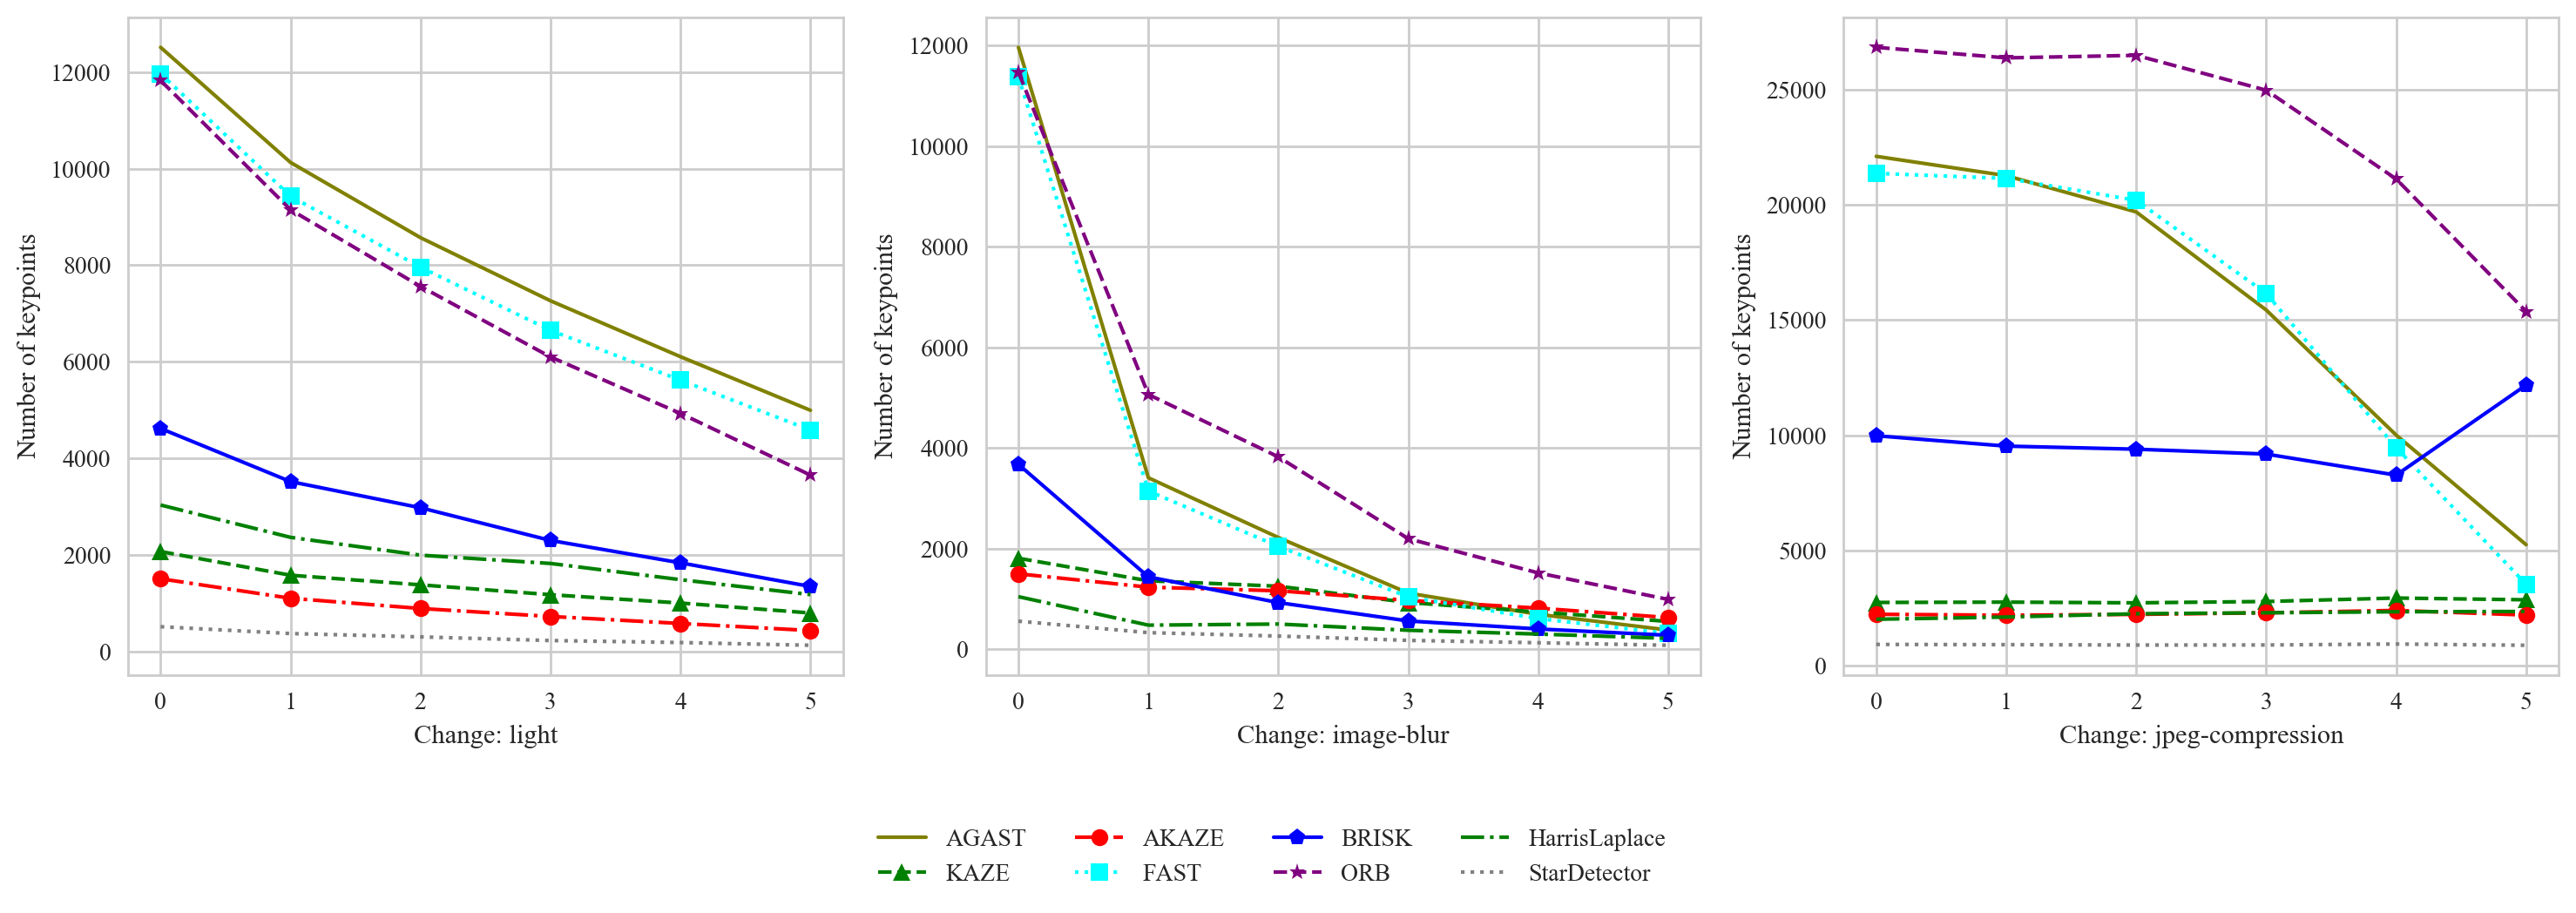

In [28]:
# plt.style.use('classic')
# fig1, axs1 = plt.subplots(1, 3, figsize=(18,5), dpi=300)
linestyle_ = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
markers = ['+', '^', 'o', 's', 'p', '*', 'x', '+', '^', 'o', 's', 'p', '*', 'x']
fig2, axs2 = plt.subplots(1, 3, figsize=(18,5), dpi=200)
axs_col = 0
for plot_data in plot_data_arr:
    i = 0
    for detector_name in dd.all_detectors: 
        execution_time, total_keypoints = plot_data[detector_name]
#         axs1[axs_col].plot(list(execution_time.keys()), list(execution_time.values()), c=colors[i], label=detector_name)
        axs2[axs_col].plot([key for key in total_keypoints.keys()], [len(value) for value in total_keypoints.values()], 
                           linestyle=linestyle_[i], linewidth=1.5, marker=markers[i], c=colors[i], label=detector_name)
        i += 1
#     axs[0, axs_col].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    variance = image_set_variance[image_set_arr[axs_col]]
#     axs1[axs_col].set_xlabel(f'Variance: {variance}')
#     axs1[axs_col].set_ylabel("Execution Time")
    
#     axs[1, axs_col].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    axs2[axs_col].set_xlabel(f'Change: {variance}')
    axs2[axs_col].set_ylabel("Number of keypoints")
    axs_col += 1
#     print(image_set_name)
# handles1, labels1 = axs1[0].get_legend_handles_labels()
handles2, labels2 = axs2[0].get_legend_handles_labels()
plt.legend(handles2, labels2, loc="upper center",bbox_to_anchor=(-0.8, -0.2), ncol = 4)
fig2.subplots_adjust(wspace = 0.2)
# fig2.subplots_adjust(wspace = 0.2)
# plt.suptitle('Execution time and total number of keypoints \ndetected accross different levels of variance', fontsize = 16, y = 1.0, color='indigo')
plt.show()

#### Gradual darkenning
__Todo__

- [ ] Change to bar plot
- [ ] Ask in stackoverflow about this checkbox problem

In [29]:
image_set_name = 'leuven'
image_set_ = util.get_image_set(data_path, image_set_name)
image_num = 4
image = image_set_['{0}_img{1}'.format(image_set_name, image_num)]
df = ex.experiment_1_df(image)
df.style. \
    apply(util.highlight_max, subset=['Execution Time', 'Number of Keypoints']). \
    apply(util.highlight_min, subset=['Execution Time', 'Number of Keypoints'])

,Detector,Execution Time,Number of Keypoints
0,AGAST,0.008195,7263
1,KAZE,0.364671,1174
2,AKAZE,0.080793,723
3,FAST,0.002097,6651
4,BRISK,0.168308,2298
5,ORB,0.008536,6100
6,HarrisLaplace,0.666570,1821
7,StarDetector,0.013923,224


#### Use set to find the intersection of the keypoints to the union

In [30]:

image_set = util.get_image_set(data_path, 'bikes')
image = image_set['bikes_img1']

execution_time, total_keypoints = ip.get_alldet_kp_et(image)
# union_keypoints = set()
# union_keypoints.update(*total_keypoints.values())
# union_keypoints = *union_keypoints.pt
# print(len(all_keypoints))

__TODO__
- [ ] Find intersection
- [ ] Graph frequncy in seaborn
- [ ] List to numpy

In [31]:
image_sequence = 'bikes'
image_set = util.get_image_set(data_path, image_sequence)
image = image_set[f'{image_sequence}_img{1}']
kp_all = {}
detector_name = 'GFTT'
# fig, axs = plt.subplots(6,1, figsize=(7,21))
sigma_range = [1,6] 
sigma_step = 1
def get_kpnp_frequency_det(image, detector_name, sigma_values):
    for sigma in sigma_values:
        if sigma is 0:
            image_blur = image
        else:
            ksize = np.int(np.round(((((sigma - 0.8)/0.3) + 1)/0.5)+1))
            if ksize % 2 == 0:
                ksize += 1
            image_blur = cv2.GaussianBlur(image,(ksize, ksize),0)


    #     print(image.shape)
    #     print(image_blur.shape)
        kp_all[sigma] = ip.get_kp(image_blur, detector_name)
    #     kpnp = ip.cvkp2np(kp_all[sigma])
    #     axs[sigma_values.index(sigma)].imshow(image_blur)
    #     axs[sigma_values.index(sigma)].scatter(kpnp[:,0],kpnp[:,1], c='r', s=2)
    
    kpnp_all = ip.cvkp2np_all(kp_all) 
    kpnp_unique = ip.get_unique_kpnp(kp_all)
    kpnp_all_frequency = ip.get_kpnp_frequency(kpnp_all, kpnp_unique)
    return kpnp_unique, kpnp_all_frequency

# kp_frequency.shape


In [ ]:
sums = 0
for i,v in kp_all.items():
    sums += len(v)
    print(len(v))
sums

In [ ]:
sums = 0
for i,v in kpnp_all.items():
    sums += v.shape[0]
    print(v.shape)
print(sums)

In [ ]:
kpnp_unique.shape

In [ ]:
kpnp_all_frequency.shape

In [51]:
image_sequence = 'bikes'
image_set = util.get_image_set(data_path, image_sequence)
image = image_set[f'{image_sequence}_img{1}']
sigma_range = [1,6] 
sigma_step = 1
sigma_values=[1+i*sigma_step for i in range(int((sigma_range[1]-sigma_range[0])/sigma_step + 1))]
frequencies = range(1, len(sigma_values)+1)
kpnp_by_frequency_det = dict()
kpnp_total_det = dict()
for detector_name in dd.all_detectors:
    kpnp_unique, kpnp_all_frequency=get_kpnp_frequency_det(image, detector_name, sigma_values)
    kpnp_by_frequency = dict()
#     print(detector_name)
#     print(kpnp_unique.shape[0])
    for frequency in frequencies:
        kpnp_by_frequency[frequency] = ip.get_kpnp_by_frequency(kpnp_all_frequency, kpnp_unique, frequency).shape[0]
#         print(f'{frequency}: {kpnp_by_frequency[frequency-1].shape[0]}')
    # 
    kpnp_by_frequency_det[detector_name] = kpnp_by_frequency
    kpnp_total_det[detector_name] = kpnp_unique.shape[0]

In [ ]:
kpnp_by_frequency_det['AGAST']

In [52]:
import numpy as np
import matplotlib.pyplot as plt


# data = [[ 66386, 174296,  75131, 577908,  32015],
#         [ 58230, 381139,  78045,  99308, 160454],
#         [ 89135,  80552, 152558, 497981, 603535],
#         [ 78415,  81858, 150656, 193263,  69638],
#         [139361, 331509, 343164, 781380,  52269]]
data = list()
for frequency in frequencies: 
    row = list()
    for detector_name in kpnp_by_frequency_det.keys():
        row.append(kpnp_by_frequency_det[detector_name][frequency])
    data.append(row)




In [ ]:
data

In [53]:
columns = tuple(list(kpnp_by_frequency_det.keys()))
# columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
rows = [frequency for frequency in frequencies]
rows.reverse()
rows

[6, 5, 4, 3, 2, 1]

In [ ]:
len(data)

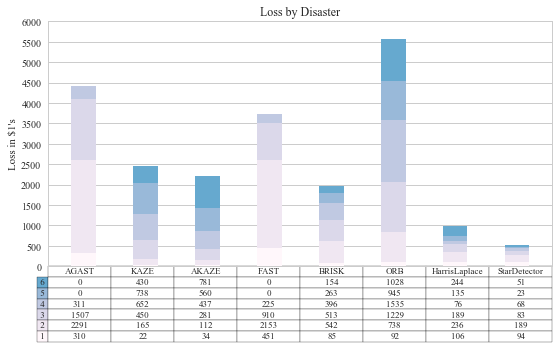

In [54]:
import numpy as np
import matplotlib.pyplot as plt


# data = [[ 66386, 174296,  75131, 577908,  32015],
#         [ 58230, 381139,  78045,  99308, 160454],
#         [ 89135,  80552, 152558, 497981, 603535],
#         [ 78415,  81858, 150656, 193263,  69638],
#         [139361, 331509, 343164, 781380,  52269]]

# columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
# rows = ['%d year' % x for x in (100, 50, 20, 10, 5)]
row_labels = [' '+str(row)+' ' for row in rows]
values = np.arange(0, 6500, 500)
value_increment = 1

# Get some pastel shades for the colors
colors = plt.cm.PuBuGn(np.linspace(0, 0.5, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))
fig, ax = plt.subplots(1, figsize=(10,5))
# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1d' % x for x in data[row]])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = ax.table(cellText=cell_text,
                      rowLabels=row_labels,
                      rowLoc='left',
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom',
                      cellLoc='center')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Loss in ${0}'s".format(value_increment))
plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Loss by Disaster')

plt.show()

In [55]:
from itertools import chain

kp_np_det = ip.cvkp2np_all(total_keypoints)
kp_np_unique = np.array(list(chain(*[value.tolist() for value in kp_np_det.values()])))
kp_np_unique= np.unique(kp_np_unique, axis=0,)
# print(kp_all.shape)
# print(kp_np.keys())

In [56]:
# keypoint_list = list(union_keypoints)
# print(keypoint_list )
point_freq = np.zeros((kp_np_unique.shape[0],1))
for i in range(0, kp_np_unique.shape[0]):
    for detector in dd.get_all_detectors().keys():
        if kp_np_unique[i] in kp_np_det[detector]:
            point_freq[i] += 1
print(point_freq)

[[2.]
 [2.]
 [3.]
 ...
 [5.]
 [6.]
 [4.]]


In [57]:
from itertools import chain

def get_kp_frequency(kp_np_det, kp_np_unique):
    
    point_freq = np.zeros((kp_np_unique.shape[0],1))
    for i in range(0, kp_np_unique.shape[0]):
        for detector in dd.get_all_detectors().keys():
            if kp_np_unique[i] in kp_np_det[detector]:
                point_freq[i] += 1
    kp_np_unique_freq = np.hstack((kp_np_unique, point_freq))
    return kp_np_unique_freq

In [58]:
# print(kp_freq.shape)
# plt.imshow(image)
# plt.show()
def get_kp_filtered_frequency(kp_np_det, kp_np_unique, frequency):
    kp_freq = get_kp_frequency(kp_np_det, kp_np_unique)
    index_matched = np.where(kp_freq[:,2] == frequency)
    kp_filtered_frequency = kp_np_unique[index_matched]
    return kp_filtered_frequency

In [59]:
def get_matched_kp_ratio_det(kp_np_det, frequency):
    kp_np_unique= np.unique(np.array(list(chain(*[value.tolist() for value in kp_np_det.values()]))), axis=0,)
    kp_filtered_frequency = get_kp_filtered_frequency(kp_np_det, kp_np_unique, frequency)
    matched_kp_ratio_det = dict()

    for detector, kp in kp_np_det.items():
        kp = kp.tolist()
        total_kp_det = len(kp)
        matched_kp_total = 0
        for kp_filtered in kp_filtered_frequency.tolist():
            if kp_filtered in kp:
                matched_kp_total += 1
        matched_kp_ratio_det[detector] = matched_kp_total/total_kp_det

    return matched_kp_ratio_det


In [60]:
image_set_name = 'leuven'
image_set_ = util.get_image_set(data_path, image_set_name)
plot_data_arr = []
kp_np_det_arr = []
# image_num = 4
for image_num in range(1,7):
#     print(1)
    image = image_set_['{0}_img{1}'.format(image_set_name, image_num)]
    execution_time, all_keypoints = ip.get_alldet_kp_et(image)
    kp_np_det_arr.append(ip.cvkp2np_all(all_keypoints))

In [ ]:
len(kp_np_det_arr)

In [61]:
def get_kp_np_det_arr(image_set_name, pckl_path):
    image_set_ = util.get_image_set(pckl_path, image_set_name)
    kp_np_det_arr = []
    # image_num = 4
    for image_num in range(1,7):
    #     print(1)
        image = image_set_['{0}_img{1}'.format(image_set_name, image_num)]
        execution_time, all_keypoints = ip.get_alldet_kp_et(image)
        kp_np_det_arr.append(ip.cvkp2np_all(all_keypoints))
    return kp_np_det_arr

def get_plot_data_arr(kp_np_det_arr, frequencies):
    plot_data_arr = []
    for kp_np_det in kp_np_det_arr:

        matched_kp_ratio_det_freq = dict()
        for frequency in frequencies:
            matched_kp_ratio_det_freq[frequency]= get_matched_kp_ratio_det(kp_np_det, frequency)

        plot_data = dict()
        for detector in dd.get_all_detectors():
            plot_data_det = list()
            for frequency in matched_kp_ratio_det_freq.keys():
                plot_data_det.append(matched_kp_ratio_det_freq[frequency][detector])
            plot_data[detector] = np.array(plot_data_det)
#     print(3)
        plot_data_arr.append(plot_data)
    return plot_data_arr

In [62]:
def experiment_2_plt(image_set_name, pckl_path, frequencies):
    kp_np_det_arr = get_kp_np_det_arr(image_set_name, pckl_path)
    plot_data_arr = get_plot_data_arr(kp_np_det_arr, frequencies)
    
    plt.style.use('bmh')
    fig, axs = plt.subplots(2, 3, figsize=(12,8))
    axs_count = 0 
    for plot_data in plot_data_arr:

        for detector, data in plot_data.items():
            axs[axs_count//3, axs_count%3].plot(frequencies, data, label=detector)
        axs[axs_count//3, axs_count%3].set_title(f"{image_set_name}_img{axs_count+1}")
        axs[axs_count//3, axs_count%3].set_xlabel('Frequency of keypoints')
        axs[axs_count//3, axs_count%3].set_ylabel('Fraction of keypoints')
    #         plt.plot(frequencies, data, label=detector)

        axs_count += 1

    handles, labels = axs[0, 0].get_legend_handles_labels()
    plt.legend(handles, labels, loc="upper center",bbox_to_anchor=(-0.8, -0.2), ncol = 3)
    fig.subplots_adjust(wspace = 0.3, hspace = 0.4)
    plt.suptitle('Execution time and total number of keypoints \ndetected accross different levels of variance', fontsize = 16, y = 1.0, color='indigo')
    plt.show()


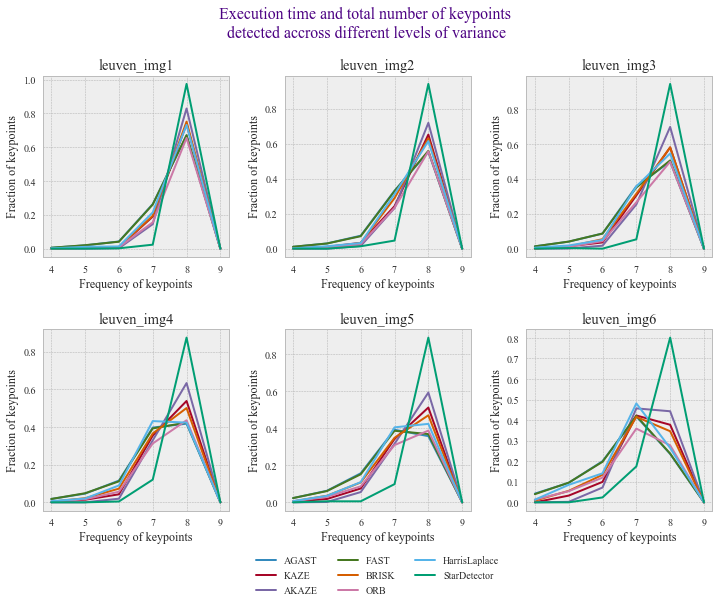

In [63]:
frequencies = [4,5,6,7,8,9]
experiment_2_plt('leuven', data_path, frequencies)

In [ ]:
frequencies = [4,5,6,7,8,9]
experiment_2_plt('bikes', data_path, frequencies)

In [ ]:
frequencies = [1,2,3,4,5,6,7,8,9]
experiment_2_plt('ubc', pckl_path, frequencies)

In [ ]:
# frequencies = [5,6,7,8,9]

# for kp_np_det in kp_np_det_arr:
#     # print(kp_np_det.values())

#     matched_kp_ratio_det_freq = dict()
#     for frequency in frequencies:
#         matched_kp_ratio_det_freq[frequency]= get_matched_kp_ratio_det(kp_np_det, frequency)
        
#     plot_data = dict()
#     for detector in dd.get_all_detectors():
#         plot_data_det = list()
#         for frequency in matched_kp_ratio_det_freq.keys():
#             plot_data_det.append(matched_kp_ratio_det_freq[frequency][detector])
#         plot_data[detector] = np.array(plot_data_det)
# #     print(3)
#     plot_data_arr.append(plot_data)

In [ ]:
len(plot_data_arr)

In [ ]:
# plt.style.use('bmh')
# fig, axs = plt.subplots(2, 3, figsize=(12,8))
# axs_count = 0 
# for plot_data in plot_data_arr:
    
#     for detector, data in plot_data.items():
#         axs[axs_count//3, axs_count%3].plot(frequencies, data, label=detector)
#     axs[axs_count//3, axs_count%3].set_title(f"{image_set_name}_img{axs_count+1}")
#     axs[axs_count//3, axs_count%3].set_xlabel('Frequency of keypoints')
#     axs[axs_count//3, axs_count%3].set_ylabel('Fraction of keypoints')
# #         plt.plot(frequencies, data, label=detector)
        
#     axs_count += 1

# handles, labels = axs[0, 0].get_legend_handles_labels()
# plt.legend(handles, labels, loc="upper center",bbox_to_anchor=(-0.8, -0.2), ncol = 3)
# fig.subplots_adjust(wspace = 0.3, hspace = 0.4)
# plt.suptitle('Execution time and total number of keypoints \ndetected accross different levels of variance', fontsize = 16, y = 1.0, color='indigo')
# plt.show()

In [ ]:
# image_set = util.get_image_set(pckl_path, 'leuven')
# image = image_set['leuven_img6']

# execution_time, total_keypoints = ip.get_alldet_kp_et(image)

In [ ]:
# kp_np_det = ip.cvkp2np(total_keypoints)
# # print(kp_np_det.values())
# frequencies = [1,2,3,4,5,6,7,8,9]

# matched_kp_ratio_det_freq = dict()
# for frequency in frequencies:
#     matched_kp_ratio_det_freq[frequency]= get_matched_kp_ratio_det(kp_np_det, frequency)

In [ ]:
# plot_data = dict()
# for detector in dd.get_all_detectors():
#     plot_data_det = list()
#     for frequency in matched_kp_ratio_det_freq.keys():
#         plot_data_det.append(matched_kp_ratio_det_freq[frequency][detector])
#     plot_data[detector] = np.array(plot_data_det)
    

In [ ]:
# for detector, data in plot_data.items():
#     plt.plot(frequencies, data, label=detector)
# plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2), ncol = 3)
# plt.show()

In [ ]:
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
